In [43]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

#  Clustering a stock portfolio for the diversification problem

### Objectives

The **goal** of this work is: to **cluster stocks using unsupervised machine learning algorithms** such as **KMeans** and **Aglomerative Hierarchical Clustering**. Stock clustering can be useful for a variety of financial and investment purposes: 


1. **Portfolio diversification**. **Diversification** helps reduce risks due to the fact that the investor doesn't invest money in any one asset, but collects a portfolio of many different assets that have little relationship with each other. Then, even if one of the investor’s securities falls in price, others are likely to rise - and the profitability on them will eventually cover the losses that have arisen.


2. **Risk and return analysis**. Understanding which stocks are clustered together can help investors assess the expected level of risk and return for each cluster. This can be useful for making decisions about how to allocate capital in a portfolio.


3. **Trend forecasting**. Clustering can identify stocks that exhibit similar behavior in the market. This can help investors identify trends and make decisions based on expected market movements.


4. **Financial market analysis**: Clustering can serve as a tool for analyzing the structure of the financial market, identifying groups of stocks with common characteristics.

 


### Dataset

First of all, I obtained data with information about the companies included in the S&P 500 index, taken from the specified web page.

[S&P 500](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) - it is a stock index consisting of shares of the 500 largest public companies in the United States

In [3]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


Then, I took  data from [Finance Yahoo](https://finance.yahoo.com/) for 2023, related to stock prices in the financial market.

In [4]:
df =yf.download(table['Symbol'].to_list(),  start = "2023-01-01" , end = "2023-12-31")
df.head() 

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-12-31)')


Adj Close                                            \
                              A    AAL        AAPL        ABBV       ABNB   
Date                                                                        
2023-01-03 00:00:00  148.957672  12.74  124.374802  154.597809  84.900002   
2023-01-04 00:00:00  150.575928  13.59  125.657639  155.845016  88.720001   
2023-01-05 00:00:00  151.012756  13.99  124.325081  155.654617  87.709999   
2023-01-06 00:00:00  146.604782  14.18  128.899521  158.567963  88.519997   
2023-01-09 00:00:00  146.406219  14.61  129.426575  153.912308  89.239998   

                                                                    \
                            ABT       ACGL         ACN        ADBE   
Date                                                                 
2023-01-03 00:00:00  106.914352  62.459999  265.065399  336.920013   
2023-01-04 00:00:00  108.504700  62.770000  264.163055  341.410004   
2023-01-05 00:00:00  108.104683  62.939999  257.925323  328.440002   
2023-01-06 00:00:00  109.597458  63.900002  264.035583  332.750000   
2023-01-09 00:00:00  109.421844  62.669998  268.488312  341.980011   

                                 ...   Volume                              \
                            ADI  ...     WYNN      XEL       XOM     XRAY   
Date                             ...                                        
2023-01-03 00:00:00  159.414200  ...  3318600  2684500  15146200  1653800   
2023-01-04 00:00:00  162.809555  ...  5743600  2265900  18058400  3697800   
2023-01-05 00:00:00  156.705780  ...  2983000  2104500  15946600  4455700   
2023-01-06 00:00:00  162.426834  ...  2901900  2976200  16348100  2058700   
2023-01-09 00:00:00  163.977325  ...  2751000  2707800  17964600  1468900   

                                                                          
                         XYL      YUM      ZBH    ZBRA     ZION      ZTS  
Date                                                                      
2023-01-03 00:00:00   812400  2307100   921100  295400  1175800  1840600  
2023-01-04 00:00:00   905900  1139400  1389400  311600  1689000  1796100  
2023-01-05 00:00:00  1295700  1078200  2238300  368200   867800  1560900  
2023-01-06 00:00:00   636200  1559400  2348900  552700  1363700  1761200  
2023-01-09 00:00:00  1224700  1211200  1423600  535400   902700  1700500  

[5 rows x 3018 columns]

The **final dataset** contains the following data:

1.  **Symbol** - ticker of comapny; short name for a financial asset, an identifier that is unique for a particular exchange.


2.  **Returns %** - measurement of the percentage change in a stock's value over a specified period of time. **A higher returns may mean higher potential income, but also comes with a higher risk of loss.**


3. **Std (Standard Deviation)** - Standard deviation measures the degree to which a stock's price varies relative to its average. **A higher standard deviation indicates higher volatility and therefore a higher level of risk.**


4. **Range:** -  The range represents the difference between the highest and lowest price of a stock over a certain period of time. **A large range may indicate high volatility and potentially higher risk.**


5. **Volume** - stock trading volume, number of shares that were bought or sold during a certain period of time (year)


6. **GICS Sector** - classification of companies based on their activities and industry.
 

In [66]:
returns = round(((df['Adj Close'].iloc[-1,:] - df['Adj Close'].iloc[1,:]) / df['Adj Close'].iloc[1,:]), 2) * 100
df2 = pd.DataFrame(returns)
df2.rename(columns = {0 : 'Returns %'}, inplace = True)

df2['Std'] = df['Adj Close'].std().round(2)
df2['Range'] = (df['High'] - df['Low']).mean().round(2)

df2['Volume'] = df['Volume'].mean()

df2.reset_index(inplace=True)


df2.rename(columns = {"index": "Symbol", 
                      0 : 'Returns %'}, inplace = True)

df2 = pd.merge(df2, table , on='Symbol', how='left')

df2.drop(columns=['Security', "GICS Sub-Industry", 'Headquarters Location', 'Date added', 'CIK',
       'Founded',], inplace=True)

df2.head()

,Symbol,Returns %,Std,Range,Volume,GICS Sector
0,A,-8.0,13.98,2.80,1845002.0,Health Care
1,AAL,1.0,1.85,0.42,27740516.8,Industrials
2,AAPL,53.0,17.50,2.88,59217028.8,Information Technology
3,ABBV,-2.0,7.10,2.47,5503482.0,Health Care
4,ABNB,53.0,13.42,4.02,6177357.2,Consumer Discretionary


### Exploratory data analysis

First, let's look at the dimension of the dataset and the number of duplicates

In [67]:
df2.shape

(503, 6)

In [68]:
print(f'Number of duplicates {df2.duplicated().sum()}')

Number of duplicates 0


Next, let's examine the null value

In [69]:
print(df2.isnull().sum().sort_values(ascending = False))
df2[df2['Returns %'].isnull()]

Returns %      4
Std            2
Range          2
Volume         2
Symbol         0
GICS Sector    0
dtype: int64


,Symbol,Returns %,Std,Range,Volume,GICS Sector
58,BF.B,NaN,NaN,NaN,NaN,Consumer Staples
69,BRK.B,NaN,NaN,NaN,NaN,Financials
273,KVUE,NaN,2.46,0.59,2.490841e+07,Consumer Staples
468,VLTO,NaN,4.26,2.30,3.118305e+06,Industrials


As we can see we have 4 null entries. Here I decided to look into the reasons for missing data. And I found the following reasons: two companies (BF.B, BRK.B) were probably excluded from S&P 500 index.

Whereas 'KVUE' and 'VLTO' began trading later. So let's deal null values

In [70]:
df2.drop(index= [58, 69], inplace=True)

df2.at[273, 'Returns %'] = round(((df['Adj Close'].iloc[-1,:]['KVUE'] - df['Adj Close'].loc[df['Adj Close']['KVUE'].first_valid_index()]['KVUE']) / 
                                                   df['Adj Close'].loc[df['Adj Close']['KVUE'].first_valid_index()]['KVUE']), 2) * 100

df2.at[468, 'Returns %'] = round(((df['Adj Close'].iloc[-1,:]['VLTO'] - df['Adj Close'].loc[df['Adj Close']['VLTO'].first_valid_index()]['VLTO']) / 
                                                   df['Adj Close'].loc[df['Adj Close']['VLTO'].first_valid_index()]['VLTO']), 2) * 100
df2.reset_index(drop=True, inplace=True)

Now, we have dealt with null values

In [71]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Symbol       501 non-null    object 
 1   Returns %    501 non-null    float64
 2   Std          501 non-null    float64
 3   Range        501 non-null    float64
 4   Volume       501 non-null    float64
 5   GICS Sector  501 non-null    object 
dtypes: float64(4), object(2)
memory usage: 23.6+ KB


From the pie chart we can see the dominant sectors in the S&P 500 Index

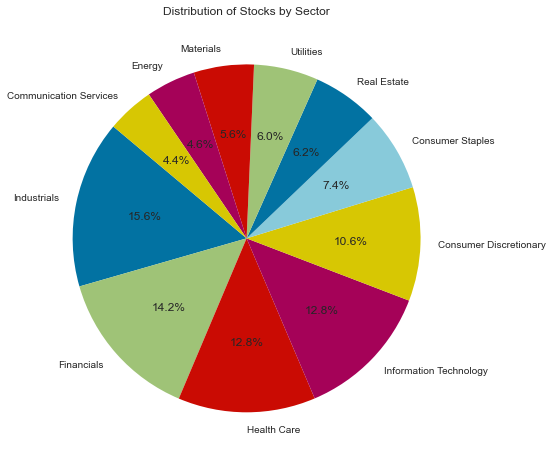

In [72]:
sector = df2['GICS Sector'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sector, labels=sector.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Stocks by Sector')
plt.show()

From the following graph we can see insights:
    
  1. The **most profitable sector** is the information technology sector, the median yield is 32%. I think this is due to the boom of artificial intelligence in 2023, and its active integration into the business processes of companies.
  
    
  2. **Unprofitable sectors** - healthcare sector, consumer Staples, utilities.

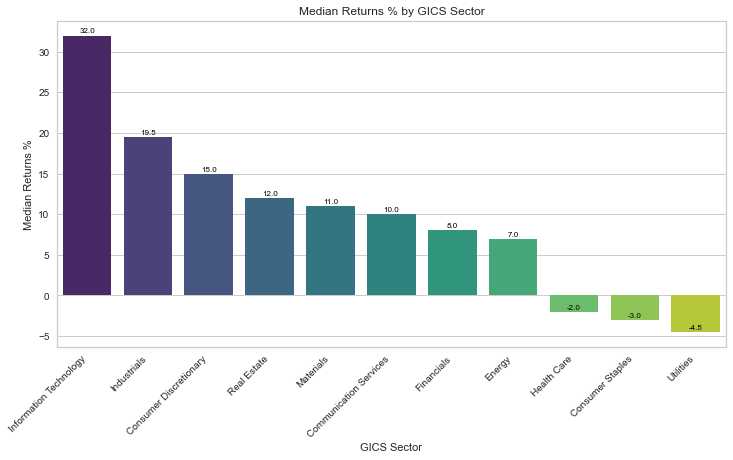

In [73]:
median_returns_by_sector = df2[['GICS Sector', 'Returns %']].groupby(['GICS Sector'], as_index=False).median().sort_values(by='Returns %', ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='GICS Sector', y='Returns %', data=median_returns_by_sector, ci=None, palette='viridis')  
plt.title('Median Returns % by GICS Sector')
plt.xlabel('GICS Sector')
plt.ylabel('Median Returns %')
plt.xticks(rotation=45, ha='right')
for index, value in enumerate(median_returns_by_sector['Returns %']):
    ax.text(index, value + 0.2, str(round(value, 2)), ha='center', va='bottom', fontsize=8, color='black')
plt.show()

Here we can see that **the most volatile** sector is information technology

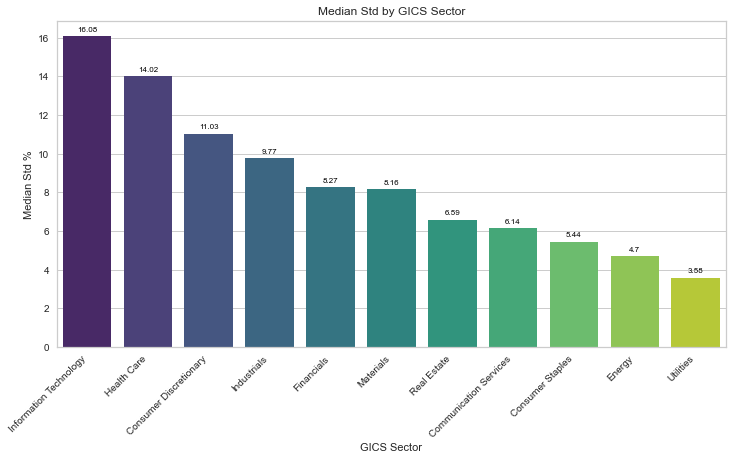

In [74]:
median_std_by_sector = df2[['GICS Sector', 'Std']].groupby(['GICS Sector'], as_index=False).median().sort_values(by='Std', ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='GICS Sector', y='Std', data=median_std_by_sector, ci=None, palette='viridis')
plt.title('Median Std by GICS Sector')
plt.xlabel('GICS Sector')
plt.ylabel('Median Std %')
plt.xticks(rotation=45, ha='right')

for index, value in enumerate(median_std_by_sector['Std']):
    ax.text(index, value + 0.2, str(round(value, 2)), ha='center', va='bottom', fontsize=8, color='black')

plt.show()

Next, let's look at the most profitable companies in 2023. **NVIDIA** is the most profitable company - 236%

In [75]:
df2.sort_values(by = 'Returns %', ascending=False)[:10]

,Symbol,Returns %,Std,Range,Volume,GICS Sector
341,NVDA,236.0,107.58,11.97,47348212.8,Information Technology
301,META,178.0,63.12,7.01,24213850.0,Communication Services
64,BLDR,150.0,26.65,3.67,1953779.2,Industrials
389,RCL,146.0,18.76,2.52,3401294.4,Consumer Discretionary
453,UBER,138.0,9.17,1.27,24506541.2,Industrials
27,AMD,128.0,17.77,3.84,61597344.4,Information Technology
369,PHM,120.0,13.84,1.71,2560153.2,Consumer Discretionary
445,TSLA,119.0,41.92,8.96,137322225.2,Consumer Discretionary
355,PANW,113.0,41.72,5.85,4571174.0,Information Technology
82,CCL,112.0,3.20,0.53,35315070.4,Consumer Discretionary


In [76]:
def draw_graph(dataframe, ticker):
    symbol = dataframe.xs(ticker, level=1, axis=1)
    symbol['Date'] = symbol.index
    symbol = symbol[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
    symbol.reset_index(drop = True, inplace=True)
    
    figure = go.Figure(data=[go.Candlestick(x=symbol["Date"],
                                        open=symbol["Open"], 
                                        high=symbol["High"],
                                        low=symbol["Low"], 
                                        close=symbol["Close"])])

    figure.update_layout(title = f'{ticker} chart price', 
                         xaxis_rangeslider_visible=False)
    figure.show()

In [77]:
draw_graph(df, 'NVDA')

Then let's look at them most unprofitable companies

In [78]:
df2.sort_values(by = 'Returns %', ascending=True)[:10]

,Symbol,Returns %,Std,Range,Volume,GICS Sector
158,ENPH,-47.0,45.70,7.44,4377044.4,Information Technology
188,FMC,-47.0,25.88,2.30,1339521.2,Materials
316,MRNA,-44.0,32.47,4.75,3890600.4,Health Care
131,DG,-44.0,43.41,3.73,2968040.4,Consumer Staples
154,EL,-43.0,48.01,4.68,2271901.6,Consumer Staples
364,PFE,-40.0,4.56,0.69,28236697.6,Health Care
21,ALB,-35.0,43.14,7.11,2249912.0,Materials
463,VFC,-33.0,3.64,0.81,7660792.8,Consumer Discretionary
357,PAYC,-32.0,48.18,7.84,668734.0,Industrials
237,ILMN,-31.0,40.31,6.12,1727149.6,Health Care


In [79]:
draw_graph(df, 'ENPH')

Next, let's examine the data for outliers. Box plot provide a visual representation of the central tendency, dispersion of the data, presence of outliers, and distribution structure for each numerical feature in the data

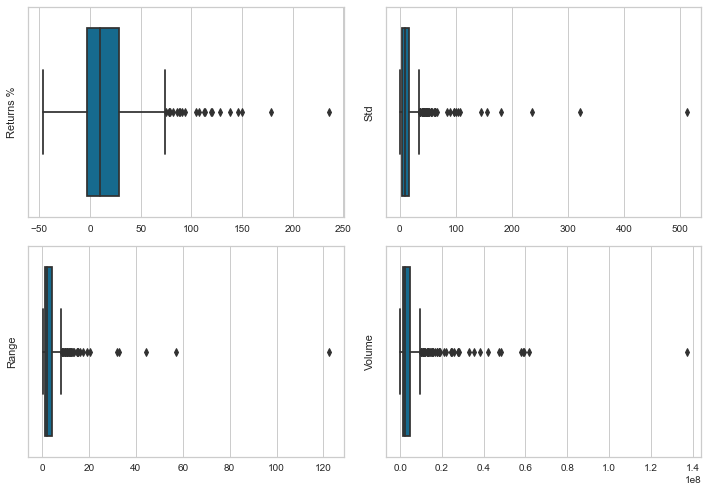

In [80]:
numerical = ['Returns %', 'Std', 'Range', 'Volume']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
for idx, feat in enumerate(numerical):
    ax = axes[int(idx / 2), idx % 2]
    sns.boxplot(x = feat,data=df2, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)
    fig.tight_layout()

### Feaure Scaling

Feature scaling is an important step when using clustering algorithms, since they are sensitive to outliers, this process helps improve the performance of the algorithms and ensure that all features are weighted equally.

I am using **Min Max Scaler**. This method scales the data so that it falls into the interval [0, 1]

In [81]:
scaler = MinMaxScaler()
columns_to_scale = ['Returns %', 'Std', 'Range', 'Volume']

df_scaled = df2.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df2[columns_to_scale])

df_scaled.describe()

,Returns %,Std,Range,Volume
count,501.000000,501.000000,501.000000,501.000000
mean,0.222685,0.032139,0.029582,0.035056
std,0.111817,0.066711,0.058032,0.071426
min,0.000000,0.000000,0.000000,0.000000
25%,0.155477,0.007728,0.008583,0.008262
50%,0.201413,0.015124,0.017247,0.015675
75%,0.265018,0.031265,0.031470,0.033128
max,1.000000,1.000000,1.000000,1.000000


In [82]:
df_scaled

,Symbol,Returns %,Std,Range,Volume,GICS Sector
0,A,0.137809,0.026276,0.021497,0.013272,Health Care
1,AAL,0.169611,0.002543,0.002043,0.201878,Industrials
2,AAPL,0.353357,0.033163,0.022151,0.431133,Information Technology
3,ABBV,0.159011,0.012815,0.018800,0.039918,Health Care
4,ABNB,0.353357,0.025180,0.031470,0.044827,Consumer Discretionary
...,...,...,...,...,...,...
496,YUM,0.176678,0.008746,0.014141,0.011327,Consumer Discretionary
497,ZBH,0.148410,0.020172,0.016593,0.011157,Health Care
498,ZBRA,0.180212,0.065524,0.060814,0.002782,Information Technology
499,ZION,0.137809,0.014478,0.011852,0.028330,Financials


### Models

#### KMeans 

Finally I decided to use the following features for clustering: Returns, Std, Range

First, I determined the optimal number of clusters for the KMeans algorith by using KElbowVisualizer and k from 2 to 12. As for the metric, I have used Distortion Score, which computes the sum of squared distances from each point to its assigned center 


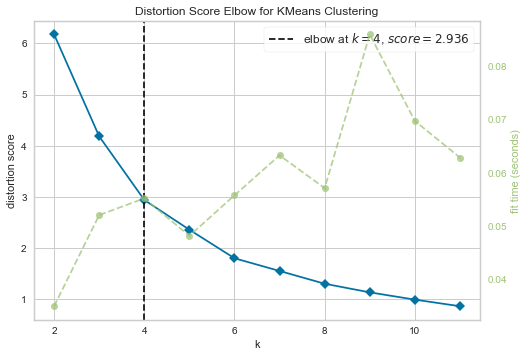

In [83]:
X = df_scaled[['Returns %', 'Std', 'Range']]

kmeans = KMeans(init = 'k-means++')

visualizer = KElbowVisualizer(kmeans, k = (2, 12), timings=True)
visualizer.fit(X)
visualizer.show();

In [84]:
km = KMeans(n_clusters = 4)
y_predicted_kmeans = km.fit_predict(X)

In [85]:
df2['Cluster_Kmeans'] = y_predicted_kmeans
df2.head()

,Symbol,Returns %,Std,Range,Volume,GICS Sector,Cluster_Kmeans
0,A,-8.0,13.98,2.80,1845002.0,Health Care,0
1,AAL,1.0,1.85,0.42,27740516.8,Industrials,0
2,AAPL,53.0,17.50,2.88,59217028.8,Information Technology,2
3,ABBV,-2.0,7.10,2.47,5503482.0,Health Care,0
4,ABNB,53.0,13.42,4.02,6177357.2,Consumer Discretionary,2


In [86]:
cluster_colors = sns.color_palette('viridis', n_colors=len(df2['Cluster_Kmeans'].unique()))

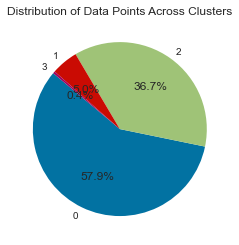

In [87]:
cluster_counts_kmeans = df2['Cluster_Kmeans'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(cluster_counts_kmeans, labels=cluster_counts_kmeans.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Data Points Across Clusters')
plt.show()

Here we can visualize the clusters

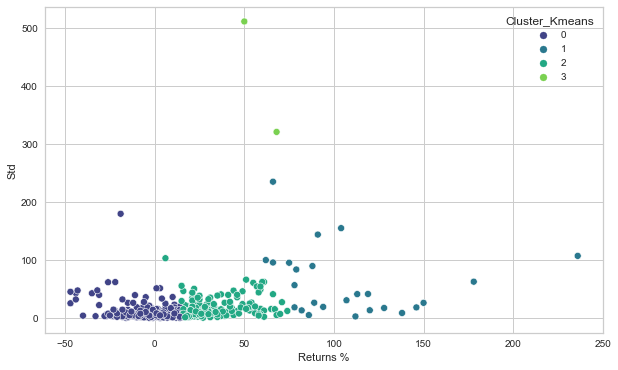

In [88]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df2, x='Returns %', y='Std', hue='Cluster_Kmeans', palette= cluster_colors)
plt.show()

Visually comparing these statistics across clusters can provide insight into the characteristics of each cluster

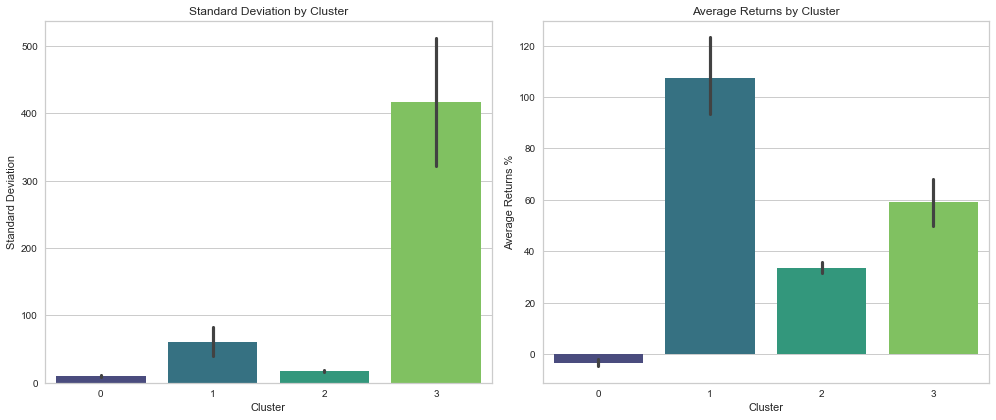

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.barplot(x='Cluster_Kmeans', y='Std', data=df2, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Standard Deviation')
axes[0].set_title('Standard Deviation by Cluster')

sns.barplot(x='Cluster_Kmeans', y='Returns %', data=df2, palette='viridis', ax=axes[1])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average Returns %')
axes[1].set_title('Average Returns by Cluster')

plt.tight_layout()

plt.show()

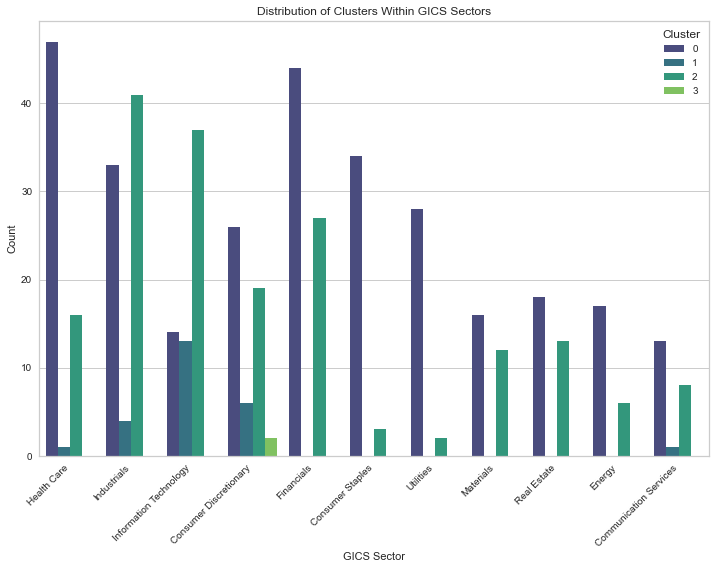

In [90]:
plt.figure(figsize=(12, 8))
sns.countplot(x='GICS Sector', hue='Cluster_Kmeans', data=df2, palette= cluster_colors)

plt.xlabel('GICS Sector')
plt.ylabel('Count')
plt.title('Distribution of Clusters Within GICS Sectors')

plt.legend(title='Cluster', loc='upper right')

plt.xticks(rotation=45, ha='right')

plt.show()

####  Agglomerative

Then let's use Agglomerative clustering technique, and for optimal number i used **silhouette score**. The silhouette score calculates the mean Silhouette Coefficient of all samples

Optimal number of clusters: 2


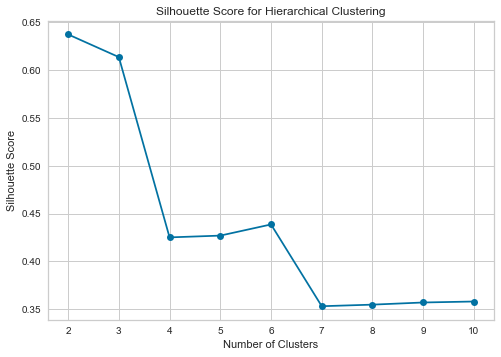

In [91]:
silhouette_scores = []
cluster_range = range(2, 11)
for n_clusters in cluster_range:
    model = AgglomerativeClustering(n_clusters = n_clusters, affinity='euclidean', linkage = 'ward')
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
optimal_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.show()

In [92]:
agglomerative = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage = 'ward')
y_predicted_agglomerative = agglomerative.fit_predict(X)
df2['Cluster_Agglomerate'] = y_predicted_agglomerative
df2.head()

,Symbol,Returns %,Std,Range,Volume,GICS Sector,Cluster_Kmeans,Cluster_Agglomerate
0,A,-8.0,13.98,2.80,1845002.0,Health Care,0,1
1,AAL,1.0,1.85,0.42,27740516.8,Industrials,0,1
2,AAPL,53.0,17.50,2.88,59217028.8,Information Technology,2,0
3,ABBV,-2.0,7.10,2.47,5503482.0,Health Care,0,1
4,ABNB,53.0,13.42,4.02,6177357.2,Consumer Discretionary,2,0


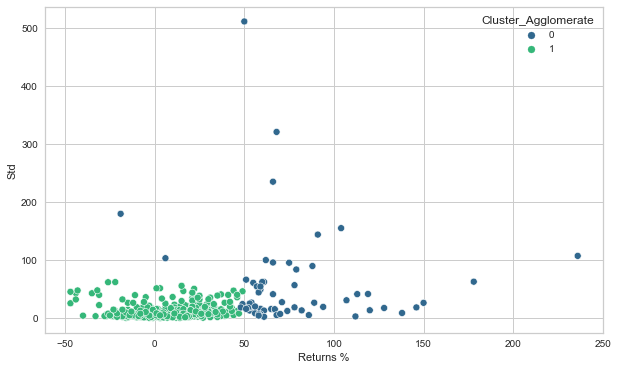

In [93]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df2, x='Returns %', y='Std', hue='Cluster_Agglomerate', palette='viridis')
plt.show()

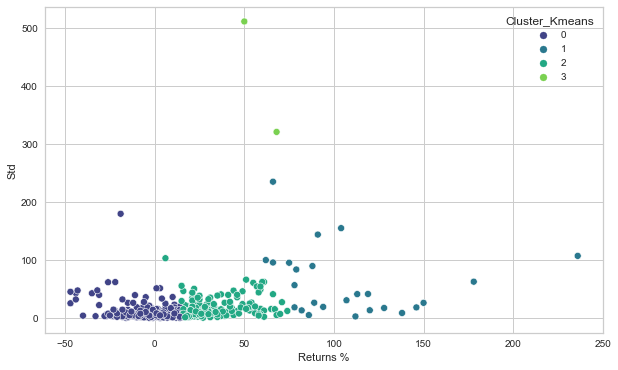

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df2, x='Returns %', y='Std', hue='Cluster_Kmeans', palette= cluster_colors)
plt.show()

### Conclusion

Finally, we can conclude that the **KMeans** worked better than Agglomerative Clustering, since the clusters are better distinguished visually, and accordingly, this allows you to more diversify your portfolio by buying shares in equal quantities from the clusters, and protect yourself from the risks of losing money funds.

### Suggestion for next steps

In addition to clustering based on risk and return. You can cluster companies according to their main financial indicators: Net profit, Equity, Long-term Debt, Revenue, Return on Equity and so on